In [153]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("mobile_addiction_cleaned.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13318 entries, 0 to 13317
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Entry number        13318 non-null  int64 
 1   daily_screen_time   13318 non-null  int64 
 2   app_sessions        13318 non-null  int64 
 3   social_media_usage  13318 non-null  int64 
 4   gaming_time         13318 non-null  int64 
 5   notifications       13318 non-null  int64 
 6   night_usage         13318 non-null  int64 
 7   age                 13318 non-null  int64 
 8   work_study_hours    13318 non-null  int64 
 9   stress_level        13318 non-null  int64 
 10  apps_installed      13318 non-null  int64 
 11  addicted            13318 non-null  object
dtypes: int64(11), object(1)
memory usage: 1.2+ MB


## Preprocessing the data

In [154]:
#check if classes are balanced
print(df["addicted"].value_counts())

#check correlation of each feature with target label
df_temp = df.copy()
df_temp["addicted"] = LabelEncoder().fit_transform(df["addicted"])
correlations = df_temp.corr(numeric_only=True)["addicted"].sort_values(ascending=False)
print(correlations)

print(df_temp.head())

addicted
not addicted    6735
addicted        6583
Name: count, dtype: int64
addicted              1.000000
age                   0.368345
work_study_hours      0.248548
Entry number          0.000547
gaming_time          -0.363429
night_usage          -0.370746
daily_screen_time    -0.382195
social_media_usage   -0.389654
apps_installed       -0.429306
stress_level         -0.535303
app_sessions         -0.672264
notifications        -0.793208
Name: addicted, dtype: float64
   Entry number  daily_screen_time  app_sessions  social_media_usage  \
0             0                  2            29                   0   
1             1                  6            29                   1   
2             2                  9            28                   2   
3             3                  6            39                   2   
4             4                  5            37                   3   

   gaming_time  notifications  night_usage  age  work_study_hours  \
0            0    

In [155]:
X = df.drop(columns=['Entry number', 'addicted', 'work_study_hours'], axis=1)
y = df['addicted'].apply(lambda x: 1 if x == 'addicted' else 0)     #label of each data point

In [156]:
#normalize data points
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
#normalize data points
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Gaussian Naive Bayes

In [160]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [161]:
y_train_pred = nb_model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

y_pred = nb_model.predict(X_test)
print("Testing Accuracy:", accuracy_score(y_test, y_pred))

Training Accuracy: 0.977473249483762
Testing Accuracy: 0.9808558558558559



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1352
           1       0.97      0.97      0.97      1312

    accuracy                           0.97      2664
   macro avg       0.97      0.97      0.97      2664
weighted avg       0.97      0.97      0.97      2664


Confusion Matrix:
 [[1317   35]
 [  33 1279]]


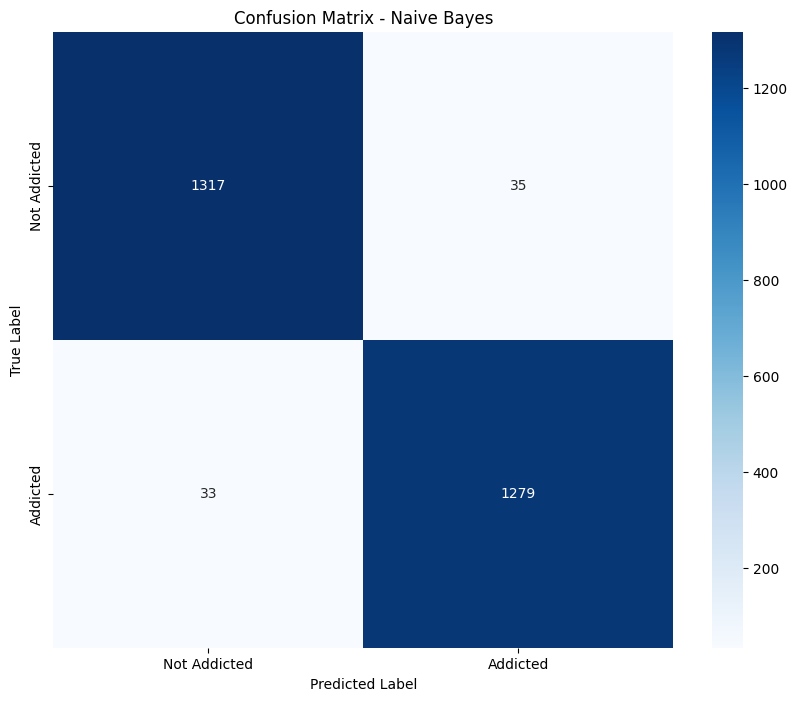

In [167]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

#plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))

labels = ["Not Addicted", "Addicted"]

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


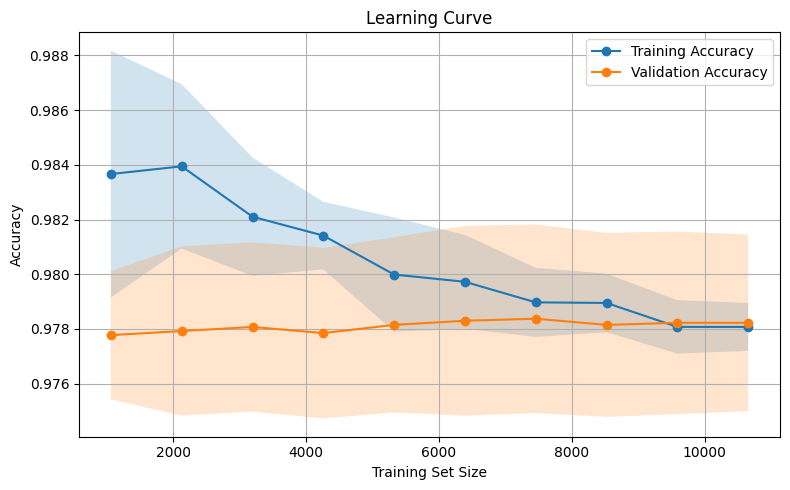

In [168]:

from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    GaussianNB(), X, y, cv=StratifiedKFold(n_splits=5),
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

AUC Score: 0.9981198811156011


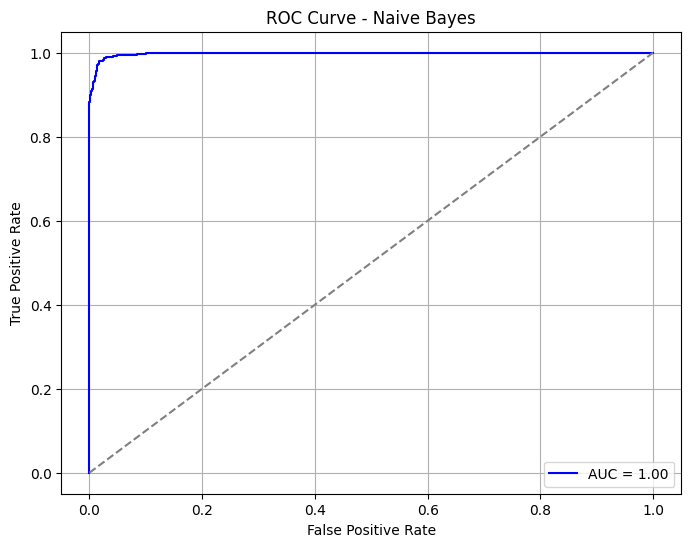

In [169]:
y_proba = nb_model.predict_proba(X_test)[:, 1]

#Compute AUC score
auc_score = roc_auc_score(y_test, y_proba)
print("AUC Score:", auc_score)

#Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend()
plt.grid(True)
plt.show()

In [177]:
#calculate AUC score for 5 folds of data
scores = cross_val_score(nb_model, X, y, cv=5, scoring='roc_auc')
print("Cross-validated AUC scores:", scores)
print("Mean AUC:", scores.mean())   #get mean of scores

Cross-validated AUC scores: [0.99854791 0.99756821 0.99698985 0.9977136  0.99771867]
Mean AUC: 0.9977076477793322


## K-Nearest Neighbours

In [170]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [171]:
y_train_pred = knn.predict(X_train_scaled)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

y_pred = knn.predict(X_test_scaled)
print("Testing Accuracy:", accuracy_score(y_test, y_pred))

Training Accuracy: 0.9830110756523371
Testing Accuracy: 0.9744744744744744



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1352
           1       0.97      0.97      0.97      1312

    accuracy                           0.97      2664
   macro avg       0.97      0.97      0.97      2664
weighted avg       0.97      0.97      0.97      2664


Confusion Matrix:
 [[1317   35]
 [  33 1279]]


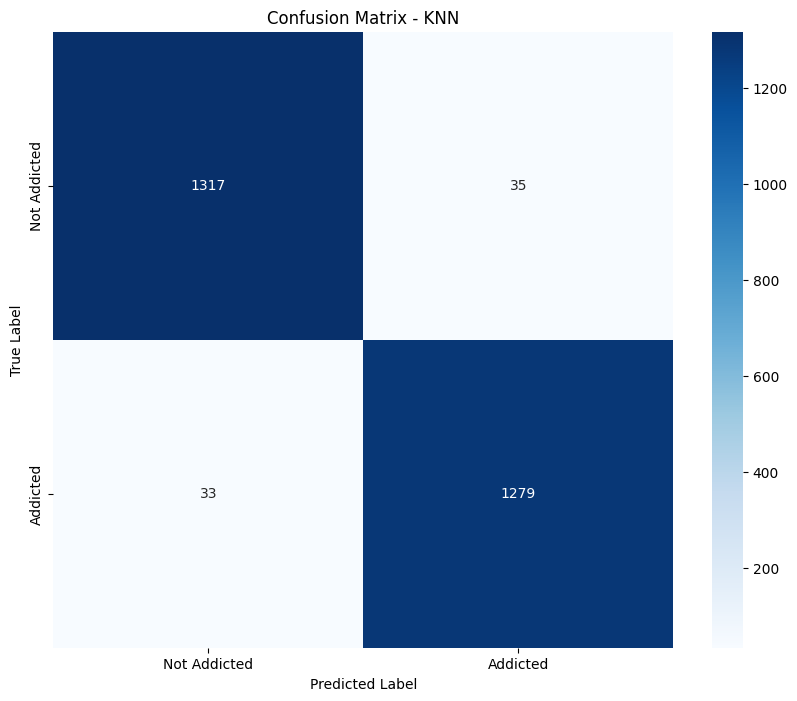

In [172]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

#plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))

labels = ["Not Addicted", "Addicted"]

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

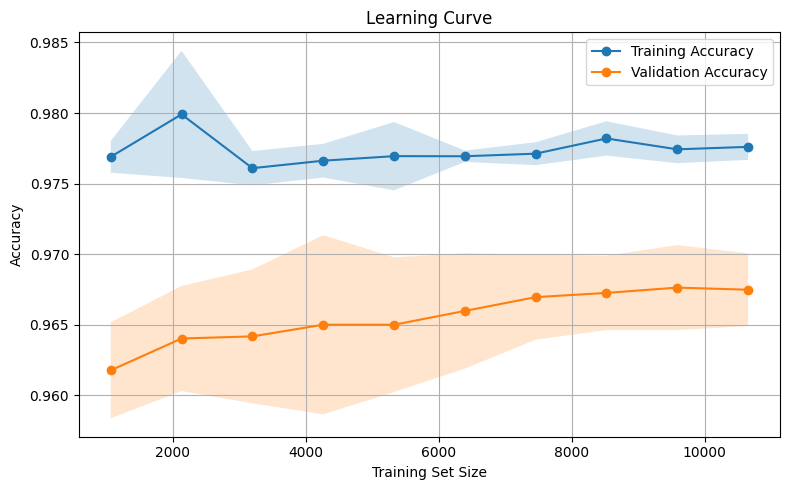

In [173]:
train_sizes, train_scores, val_scores = learning_curve(
    KNeighborsClassifier(n_neighbors=5), X, y, cv=StratifiedKFold(n_splits=5),
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

AUC Score: 0.9927952265839226


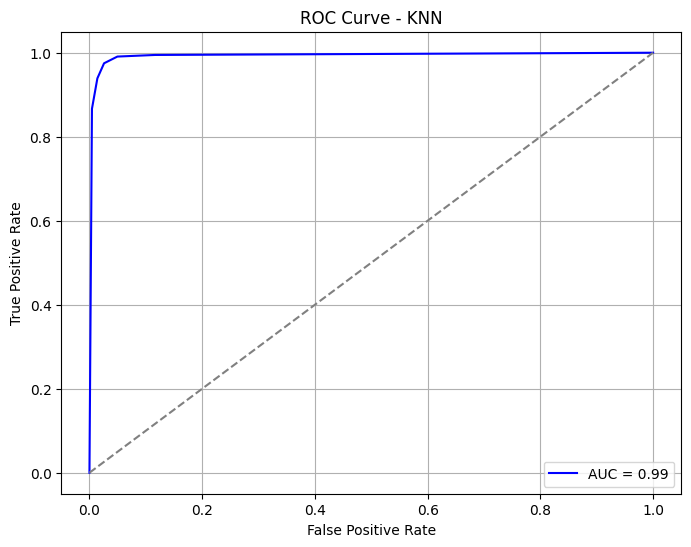

In [175]:
y_proba = knn.predict_proba(X_test_scaled)[:, 1]  #get probabilites of a data point being in each class

#Compute AUC score
auc_score = roc_auc_score(y_test, y_proba)
print("AUC Score:", auc_score)

#Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN")
plt.legend()
plt.grid(True)
plt.show()

In [176]:
#calculate AUC score for 5 folds of data
scores = cross_val_score(knn, X, y, cv=5, scoring='roc_auc')
print("Cross-validated AUC scores:", scores)
print("Mean AUC:", scores.mean())   #get mean of scores

Cross-validated AUC scores: [0.98970546 0.98891769 0.98925929 0.99014443 0.98855077]
Mean AUC: 0.9893155297642909


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [178]:
y_train_pred = dt_model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

y_pred = dt_model.predict(X_test)
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
#y_proba = dt_model.predict_proba(X_test)[:, 1]   #get probabilites of a data point being in each class

Training Accuracy: 1.0
Testing Accuracy: 0.9542042042042042


Confusion Matrix:
 [[1290   62]
 [  60 1252]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      1352
           1       0.95      0.95      0.95      1312

    accuracy                           0.95      2664
   macro avg       0.95      0.95      0.95      2664
weighted avg       0.95      0.95      0.95      2664



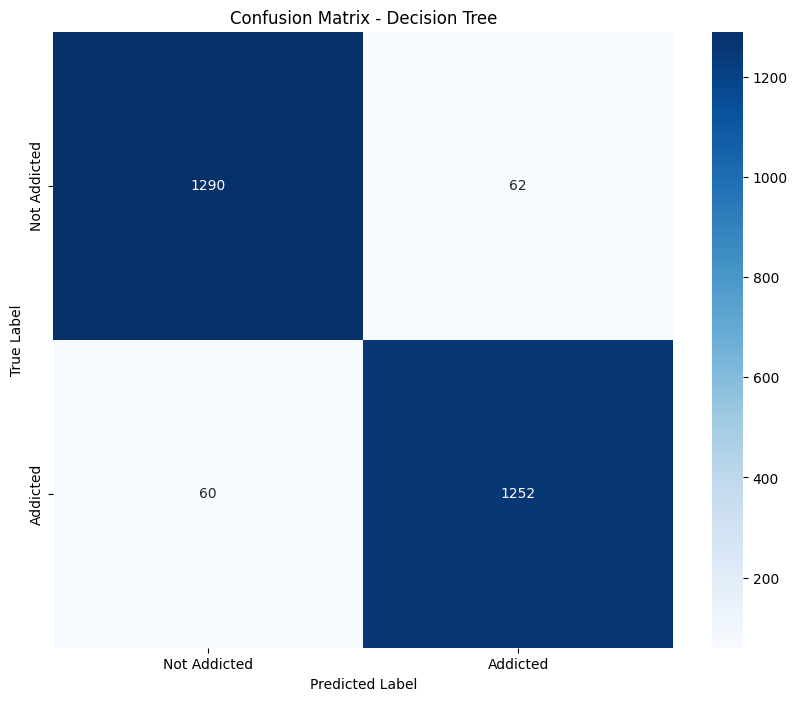

In [180]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))

labels = ["Not Addicted", "Addicted"]

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

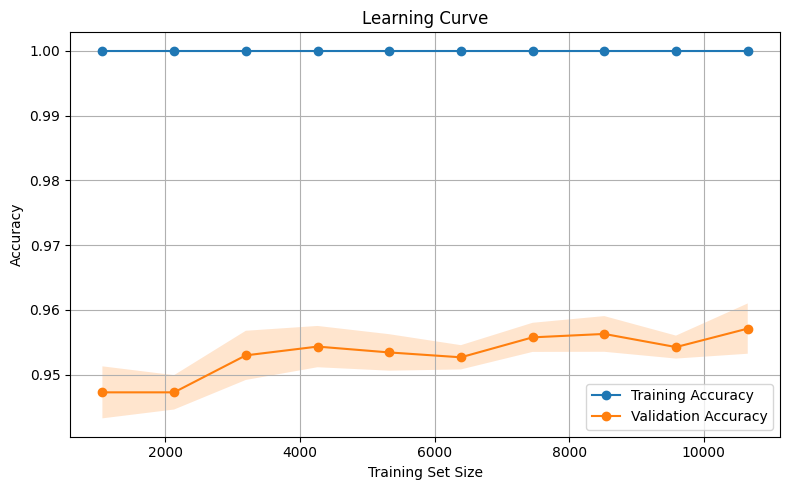

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    DecisionTreeClassifier(random_state=42), X, y, cv=StratifiedKFold(n_splits=5),
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

AUC Score: 0.9542051522586232


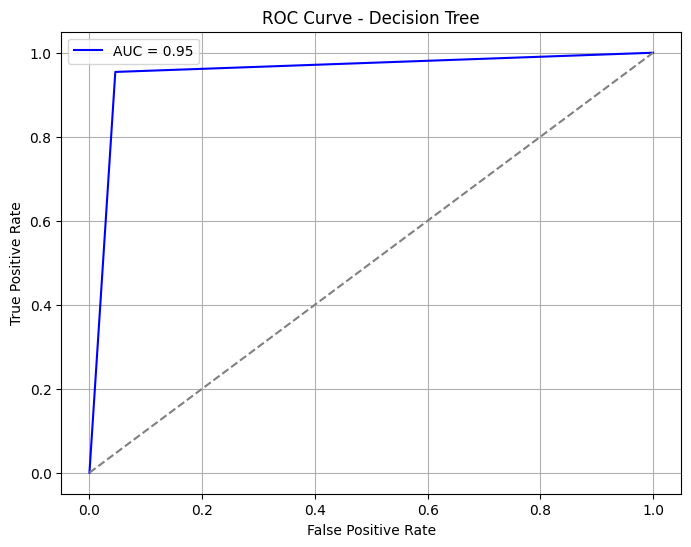

In [ ]:
# Compute AUC score
auc_score = roc_auc_score(y_test, y_proba)
print("AUC Score:", auc_score)

#Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#calculate AUC score for 5 folds of data
scores = cross_val_score(dt_model, X, y, cv=5, scoring='roc_auc')
print("Cross-validated AUC scores:", scores)
print("Mean AUC:", scores.mean())   #get mean of scores

Cross-validated AUC scores: [0.95608819 0.95882185 0.95188667 0.95520694 0.96352189]
Mean AUC: 0.9571051085976444


## Random Forest

In [ ]:

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [182]:
y_train_pred = clf.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

y_pred = clf.predict(X_test)
print("Testing Accuracy:", accuracy_score(y_test, y_pred))

Training Accuracy: 1.0
Testing Accuracy: 0.978978978978979



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1352
           1       0.98      0.98      0.98      1312

    accuracy                           0.98      2664
   macro avg       0.98      0.98      0.98      2664
weighted avg       0.98      0.98      0.98      2664


Confusion Matrix:
 [[1323   29]
 [  27 1285]]


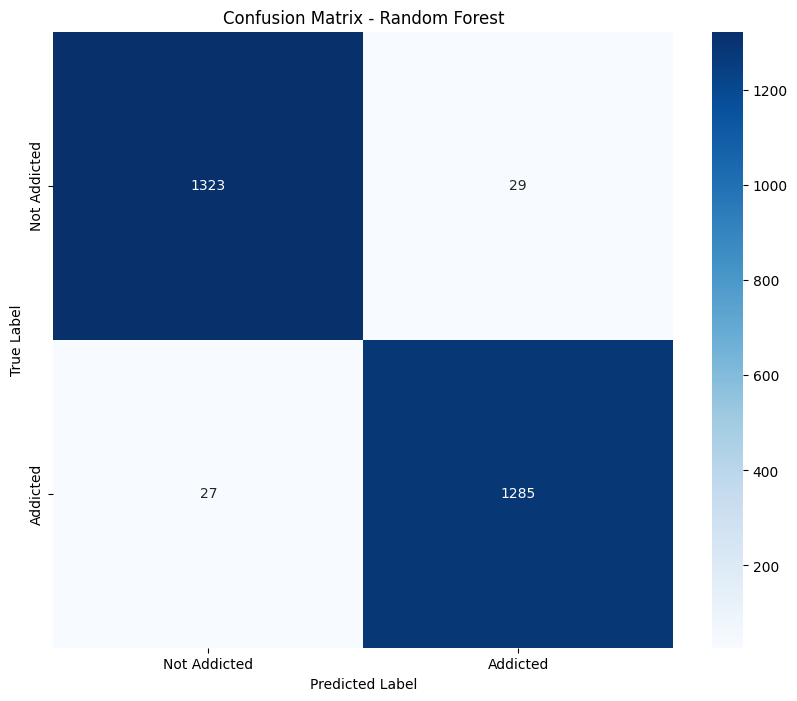

In [183]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

#plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))

labels = ["Not Addicted", "Addicted"]

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

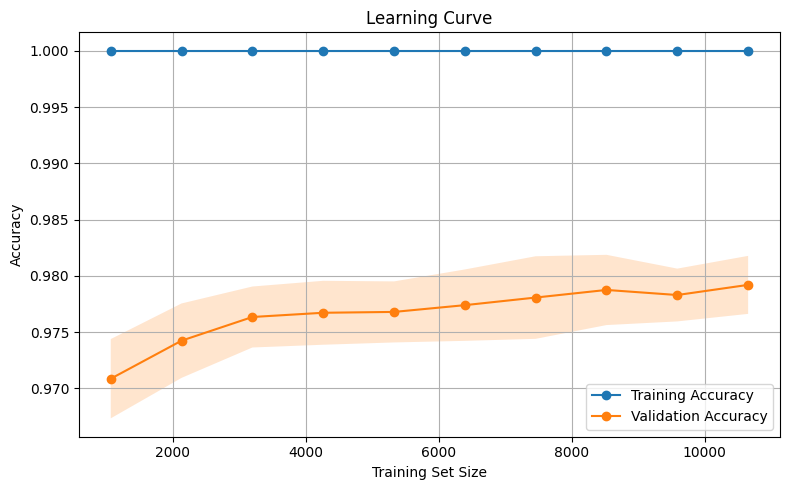

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(n_estimators=200, random_state=42), X, y, cv=StratifiedKFold(n_splits=5),
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

AUC Score: 0.9968799046579594


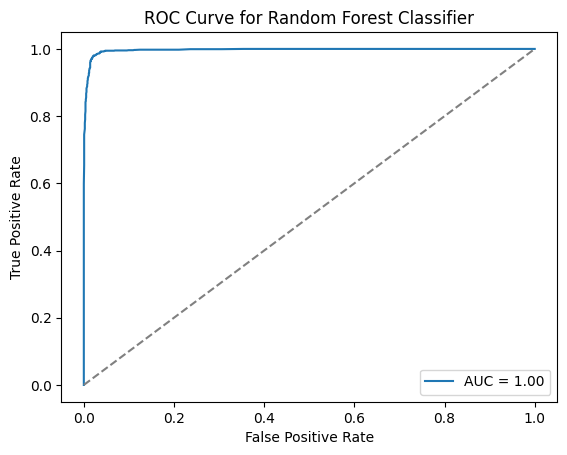

In [ ]:
# Get prediction probabilities
y_probs = clf.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_probs)
print("AUC Score:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend()
plt.show()

In [184]:
#calculate AUC score for 5 folds of data
scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print("Cross-validated AUC scores:", scores)
print("Mean AUC:", scores.mean())   #get mean of scores

Cross-validated AUC scores: [0.99795039 0.99689318 0.99655129 0.99722647 0.99693228]
Mean AUC: 0.9971107234940838
